Feb 1, 2019 - This script imports a L2 geotiff files from USGS. Units of the USGS product is Reflectance (R). Files include all cloud free images through the year from 1982 to 2018 (n=88) to run through MESMA (Multiple Endmember Spectral Mixture Analysis - developed by Roberts et al) based on basic code shared by Tom Bell.

The script uses gdal.Open().ReadAsArray() to load subset ENVI files (created from Dennis Finger handmade ROI file) as an array into python.

MESMA algorithim is run on each image to determine the fraction of kelp per pixel. The percent kelp threshold for a single pixel is 20% (0.2). If a pixel contains >=0.2 and <=1, the fractional area is calculated by taking the product of the MESMA kelp fraction and the pixel area (900m2). Currently, this threshold value is not validated. 

Oct. 9, 2019 - The script was modified to get Latitude and Longitude information from the envi files and converted into a numpy array. 
Nov. 11, 2019 - The script was modified to use new ROI for Mendocino and Sonoma Counties and using external HD rather than Google Drive. 


In [1]:
import os
import sys
import time
import glob
import gdal
import rasterio
import pandas as pd
from affine import Affine
from pyproj import Proj, transform
from rasterio.plot import show
import numpy as np
from scipy.stats.mstats import gmean
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime
import concurrent.futures
from multiprocessing import cpu_count

In [6]:
# change dir to Bull Kelp drive
#os.chdir('/Volumes/GoogleDrive/My Drive/Bull Kelp Drive')


filelist = glob.glob('/Volumes/Mere/Python_MESMA/NorthCoastImagery_045033_046032/*/merged/*_subset_v3.tif')
#filelist.extend(glob.glob('/Volumes/Mere/Python_MESMA/NorthCoastImagery_045033_046032/2013/merged/*_merged.tif'))


'''

# for comparison to Tom's MESMA results for our ROI (ver1 made by Dennis Finger - Bodega to Pt. Arena)
filelist =['NorthCoastImagery/2008/merged/LT05_LT05_20080831_20080923_subset_v2.tif',
           'NorthCoastImagery/2018/merged/LC08_LC08_20180919_20181030_subset_v2.tif']
'''

'''
# for compiling all cloud free images from 1982 to 2018 from Bull kelp Drive - Dennis Finger created ROI and subset images
filelist = glob.glob('*/LT04*_4b')
filelist.extend(glob.glob('*/LT05*_4b'))
filelist.extend(glob.glob('*/LT05*_4b_v2'))
filelist.extend(glob.glob('*/LT05*_4b_v2_mask'))
filelist.extend(glob.glob('*/LT05*_4b_2'))
filelist.extend(glob.glob('*/LC08*_4b'))
filelist.extend(glob.glob('*/LT05*_4bmask'))
filelist.extend(glob.glob('*/LT05*_4b_mask'))
filelist.extend(glob.glob('*/LC08*_4b_mask'))
filelist.extend(glob.glob('*/LC08*_4b_trialmask'))
filelist.extend(glob.glob('*/LC08*_4b_masked'))
filelist.extend(glob.glob('*/LC08*_4bmask'))
filelist.extend(glob.glob('*/LC08*_4bands'))
'''

'''
# for annual max runs from Bull kelp drive - Dennis Finger created ROI and subset images
filelist = ['19851003/LT05_L1TP_045033_19851003_20161004_01_T1_sr_subset_4b','19860920/LT05_L1TP_045033_19860920_20161003_01_T1_subset_4b',
            '19870822/LT05_L1TP_045033_19870822_20161003_01_T1_subset_4b','19880824/LT05_L1TP_045033_19880824_20161002_01_T1_subset_4b',
            '19891107/LT04_L1TP_045033_19891107_20161001_01_T1_subset_4b','19900915/LT05_L1TP_045033_19900915_20160930_01_T1_subset_4b',
            '19910902/LT05_L1TP_045033_19910902_20160929_01_T1_subset_4b_v2','19920904/LT05_L1TP_045033_19920904_20160929_01_T1_subset_4b',
            '19931025/LT05_L1TP_045033_19931025_20160927_01_T1_subset_4b','19941113/LT05_L1TP_045033_19941113_20160927_01_T1_subset_4b',
            '19950929/LT05_L1TP_045033_19950929_20160926_01_T1_subset_4b','19961017/LT05_L1TP_045033_19961017_20160924_01_T1_subset_4b',
            '19970918/LT05_L1TP_045033_19970918_20160923_01_T1_subset_4b','19981023/LT05_L1TP_045033_19981023_20160922_01_T1_subset_4b_mask',
            '20010929/LT05_L1TP_045033_20010929_20160917_01_T1_subset_4b','20020916/LT05_L1TP_045033_20020916_20160916_01_T1_subset_4b',
            '20030919/LT05_L1TP_045033_20030919_20160915_01_T1_subset_4b','20040921/LT05_L1TP_045033_20040921_20160913_01_T1_subset_4b',
            '20050924/LT05_L1TP_045033_20050924_20160911_01_T1_subset_4b','20061114/LT05_L1TP_045033_20061114_20160911_01_T1_subset_4b',
            '20070829/LT05_L1TP_045033_20070829_20160907_01_T1_subset_4b','20080831/LT05_L1TP_045033_20080831_20160906_01_T1_subset_4b',
            '20090903/LT05_L1TP_045033_20090903_20160903_01_T1_subset_4b','20100922/LT05_L1TP_045033_20100922_20160831_01_T1_subset_4b_v2_mask',
            '20131016/LC08_L1TP_045033_20131016_20170308_01_T1_subset_mask_4bands','20140901/LC08_L1TP_045033_20140901_20170303_01_T1_subset_4b',
            '20150904/LC08_L1TP_045033_20150904_20170225_01_T1_subset_4b','20160906/LC08_L1TP_045033_20160906_20170222_01_T1_subset_4b',
            '20170925/LC08_L1TP_045033_20170925_20171013_01_T1_subset_4b_trialmask','20181030/LC08_L1TP_045033_20181030_subset_4b']

'''

'''
# for CDFW matchup runs from Bull kelp drive - Dennis Finger created ROI and subset images
filelist = ['19891107/LT04_L1TP_045033_19891107_20161001_01_T1_subset_4b',
            '20030919/LT05_L1TP_045033_20030919_20160915_01_T1_subset_4b',
            '20040921/LT05_L1TP_045033_20040921_20160913_01_T1_subset_4b',
            '20050924/LT05_L1TP_045033_20050924_20160911_01_T1_subset_4b',
            '20080831/LT05_L1TP_045033_20080831_20160906_01_T1_subset_4b',
            '20091005/LT05_L1TP_045033_20091005_20160905_01_T1_subset_4b',
            '20140917/LC08_L1TP_045033_20140629_subset_4b',
            '20150920/LC08_L1TP_045033_20150920_20170225_01_T1_subset_4b_mask',
            '20161008/LC08_L1TP_045033_20161008_20170220_01_T1_subset_4b_masked']
'''

filelist.sort()


In [8]:
# Get Lat/Lon array from one of the envi files - they should all be the same
# source: 
# https://gis.stackexchange.com/questions/129847/obtain-coordinates-and-corresponding-pixel-values-from-geotiff-using-python-gdal


# Read raster
with rasterio.open(filelist[0]) as r:
    T0 = r.transform  # upper-left pixel corner affine transform
    p1 = Proj(r.crs)
    A = r.read()  # pixel values

# All rows and columns
cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

# Get affine transform for pixel centres
T1 = T0 * Affine.translation(0.5, 0.5)
# Function to convert pixel row/column index (from 0) to easting/northing at centre
rc2en = lambda r, c: (c, r) * T1

# All eastings and northings (there is probably a faster way to do this)
eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)

# Project all longitudes, latitudes
p2 = Proj(proj='latlong',datum='WGS84')
longs, lats = transform(p1, p2, eastings, northings)

# find min and max UTM coordinates of ROI region
minX = np.min(eastings)
maxX = np.max(eastings)
minY = np.min(northings)
maxY = np.max(northings)

minLon = np.min(longs)
maxLon = np.max(longs)
minLat = np.min(lats)
maxLat = np.max(lats)

# np.savetxt('/Volumes/Mere/Python_MESMA/PyMESMA_McPhersonROI_timeseries_results/to_fix/FullROI_lats.txt',lats)
# np.savetxt('/Volumes/Mere/Python_MESMA/PyMESMA_McPhersonROI_timeseries_results/to_fix/FullROI_longs.txt',longs)

<ipython-input-8-457656d64e2c>:18: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2en = lambda r, c: (c, r) * T1
<ipython-input-8-457656d64e2c>:25: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  longs, lats = transform(p1, p2, eastings, northings)


In [46]:
# create empty array of zeros for MESMA summary of MESMA output data
now = datetime.now()
sp = 'nereo'

# create an array to fill from mesma (year, month, day)
kelp_output = pd.DataFrame(columns = ['Year','Imagedate1','Imagedate2','Area(km2)','FractionalSum'])

# for f in range(len(filelist)):
#     kelp_output[f,0] = int(filelist[f][60:64])
#     kelp_output[f,1] = filelist[0][87:95]
#     kelp_output[f,2] = filelist[0][96:104]
    

# Define the fractional range of the model
kelp_lb = 0.2
kelp_ub = 1.0

frac_range = 'MESMA fraction range = %0.1f - %0.1f' %(kelp_lb,kelp_ub)
print(frac_range)

# load txt file with standard locations for water
water_file = np.loadtxt('/Volumes/Mere/Python_MESMA/McPhersonROI/McPhersonROI_waterEM/McPherson_waterEMv2.csv', 
                        delimiter = ',',
                        skiprows = 9)

t1 = time.perf_counter()

#for filename in filelist:
def mesma(filename):
    #t2 = time.perf_counter()
    print('running...',filename)
    
    # choose a name to save the file as later in the script
    saveas = filename[71:98]
    image1 = saveas[10:18]
    image2 = saveas[19:28]
    date_string  = f'{datetime.now():%Y%m%d}'
    
    # open the 4 band raster using GDAL
    # problems getting Jupyterlabs to open the raster using gdal, so gdal.USeExceptions to get around
    # the problem of NoneType error
    gdal.UseExceptions()
    ds=None
    open_array = gdal.Open(filename).ReadAsArray()[0:4,:,:]
    #print('image opened')

    
    #ref_offset = np.min(open_array)
    #ref_offset = open_array[open_array > 0].min()
    
    #Get dimensions of the array
    nrows = open_array.shape[1]
    ncols = open_array.shape[2]
    nbands = len(open_array)

    ###############################################################################
    ###### THIS IS A TRANSLATION OF TOM BELL'S MATLAB MESMA CODE INTO PYTHON ######
    ###############################################################################

    # This is the kelp endmember Tom Bell has used for all his work; this refelectance
    # is syptical of brown algae and shouldn't have to be change for nereo; this 
    # represents refelctance in digital numbers for the blue, green, red, and NIR 
    # bands for Landsat
    # giant kelp endmember created by Kyle Cavannaugh
    #sp = 'macro'
    #kelp = np.array([[495,556,437,1227]]).reshape((4,1)) - ref_offset

    # bull kelp endmember created using EAR in ENVI ViperTool
    kelp = np.array([[344,383,275,920]]).reshape((4,1))# - ref_offset
    
    # Create a bunch of constants and empty arrays to populate with MESMA results
    water_comp = np.zeros((len(water_file),nbands))
    frac_water = np.zeros((len(water_file),nrows,ncols))
    frac_kelp = np.zeros((len(water_file),nrows,ncols))
    frac_total = np.zeros((len(water_file),nrows,ncols))
    rmse = np.zeros((len(water_file),nrows,ncols))
    best_rmse = np.zeros((nrows,ncols))
    location = np.zeros((nrows,ncols))
    best_frac_kelp = np.zeros((nrows,ncols))
    pixel_frac_area = np.zeros((nrows,ncols))
    best_frac_total = np.zeros((nrows,ncols))
    
    
    for n in range(len(water_file)):
        
        resids = np.zeros((nbands,nrows,ncols))
        
        water_comp[n,:] = open_array[:,int(water_file[n,1]),int(water_file[n,0])] #- ref_offset
        water = water_comp[n,:].reshape((4,1))
        
        if np.any( water < 0 ):
            water_comp[n,:] = np.NaN
            frac_total[n,:,:] = np.NaN
            frac_kelp[n,:,:] = np.NaN
            rmse[n,:,:] = np.NaN  
            #continue
            
        else:
            # Here, can create an array of one of your seawater endmembers and kelp 
            # endmembers.  The seawater endmember will be one of 30 (or so) endmembers 
            # you choose from deep water ocean pixels in each image
            E = np.matrix(np.hstack((water, kelp)))

            # Here, perform a singular value decomposition of the endmember array. 
            # Singular  value decomposition is 
            # In the matlab code, Tom used 0 to produce an economy size  decomposition. 
            # I've put full_matrices=False, which I believe is the correct syntax in Python
            U,S,V = np.linalg.svd(E, full_matrices=False) 

            # Here, divide the V (eigenvector) term by the S term (basically eigenvalues)
            # and multiply the IS term by the transposed U matrix
            em_inv = V/S * U.T #(2,4)   

            for r in range(nrows):
                for c in range(ncols):
                    # Now multiply this em_inv matrix by pixel reflectance to obtain 
                    # the fraction of seawater and fraction of kelp in the pixel
                    image_band = open_array[:,r,c].reshape((4,1))

                    if image_band[0] > 0.0:
                        #print(image_band)
                        frac_calc = em_inv * image_band
                        frac_water[n,r,c] = frac_calc[0,0]
                        frac_kelp[n,r,c] = frac_calc[1,0]

                        # filter out kelp fractons greater than 1 and less than 0.2, and less than water fraction
                        if np.logical_and(np.logical_and(frac_kelp[n,r,c]<=1.0,frac_kelp[n,r,c]>=0.2),frac_kelp[n,r,c]>frac_water[n,r,c]):
                            frac_total[n,r,c] = frac_water[n,r,c]+frac_kelp[n,r,c]
                            #print('frac water+kelp = ',frac_total[n,r,c])

                            # Obtain modeled reflectance by multiplying endmembers by the fractions.
                            model_calc = E[:,0]*frac_water[n,r,c] + E[:,1]*frac_kelp[n,r,c]

                            # subtract modeled reflectance from pixel reflectance to 
                            # obtain residuals across the 4 bands. Divide by 10000 to put the 
                            # RMSE into more relatable terms
                            for z in range(nbands):
                                resids[z,r,c] = (image_band[z] - model_calc[z])/10000

                            # Once you choose the best model you ouput the fractions associated with it.

                            # This is calculating for every pixel within the ROI
                            rmse[n,r,c] = np.sqrt(sum(resids[:,r,c]**2)/4)
                            if rmse[n,r,c]>0.01:
                                rmse[n,r,c] = np.NaN
                        else:
                            frac_total[n,r,c] = np.NaN
                            frac_kelp[n,r,c] = np.NaN
                            rmse[n,r,c] = np.NaN

    print('mesma complete')
    
    for r in range(nrows):
        for c in range(ncols):
            try:
                get_loc = np.unravel_index(np.nanargmin(rmse[:,r,c]), rmse.shape)
                location[r,c] = get_loc[2]
                
                # final output is using the frac_kelp from the best rmse score for each pixel
                best_rmse[r,c] = rmse[int(location[r,c]),r,c]
                best_frac_kelp[r,c] = frac_kelp[int(location[r,c]),r,c]
                best_frac_total[r,c] = frac_total[int(location[r,c]),r,c]
                pixel_frac_area[r,c] = best_frac_kelp[r,c]*900
                
            except ValueError:
                get_loc = (0,0,0)
                location[r,c] = get_loc[2]

    frac_area = np.nansum(pixel_frac_area)
    frac_sum = np.nansum(best_frac_kelp)
    #print('sum of fractional area (km2) =', frac_area/1000000)
    #print('sum of kelp fractions = ', frac_sum)
    
    # get location and kelp fraction output
    kelp_loc = np.where(np.nan_to_num(best_frac_kelp, nan=0.0)>0.0)
    
    kelp_northings = np.array(northings[kelp_loc[0],kelp_loc[1]]).reshape(-1,1)
    kelp_lats = np.array(lats[kelp_loc[0],kelp_loc[1]]).reshape(-1,1)
    kelp_eastings = np.array(eastings[kelp_loc[0],kelp_loc[1]]).reshape(-1,1)
    kelp_lons = np.array(longs[kelp_loc[0],kelp_loc[1]]).reshape(-1,1)
    kelp_vals = np.array(best_frac_kelp[kelp_loc[0],kelp_loc[1]]).reshape(-1,1)
    kelp_annual_loc = np.hstack((kelp_northings,kelp_lats,kelp_eastings,kelp_lons,kelp_vals))
    
    # -- Plot summary plots for each image
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize=(11,4))
    cmap = plt.cm.jet
    cmap.set_bad(color='gainsboro')
    im = ax1.imshow(best_frac_kelp, aspect='auto',cmap=cmap)
    ax1.text(0.90, 0.8, 'kelp frac area \n = \n {0:.3f} km2'.format(frac_area/1000000),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax1.transAxes,
        color='white', fontsize=11)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax2.plot(water_comp.T)
    ax2.set(xlabel = 'Band number',
            ylabel = 'Water Endmember Reflectance',
            xticks = np.arange(1,5,1))
    ax3.hist(best_frac_kelp[~np.isnan(best_frac_kelp)],bins=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    ax3.set(xlabel = 'MESMA kelp fraction',
            ylabel = 'frequency')
    fig.suptitle('LS_{0}_PyMESMA_{1}'.format(sp,saveas))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    #fig.savefig(f'/Volumes/Mere/Python_MESMA/PyMESMA_McPhersonROI_timeseries_results/LS_PyMESMA_{saveas}_{date_string}.pdf')
    
    
    # ----- add data to the summary output array and save as textfile
    
    kelp_area = f'{saveas} fractional area = {frac_area/1000000} km2'
    kelp_area = f'{saveas} fractional sum = {frac_sum}'
    print(kelp_area)
    
    print(f'{saveas} saving files...')
    
    #     np.savetxt(f'/Volumes/Mere/Python_MESMA/PyMESMA_McPhersonROI_timeseries_results/LS_PyMESMA_{saveas}_{date_string}.csv',
    #                     kelp_annual_loc, 
    #                     delimiter=",", 
    #                     fmt = '%i %0.7f %i %0.7f %0.5f',
    #                     header = f'Python MESMA for {saveas} run on {date_string} \n {frac_range} \n Northings (y); Latitude; Eastings (x) Longitude; Kelp Fraction')

    # for later processing of autocorrelation, etc.
    #     np.savetxt(f'/Volumes/Mere/Python_MESMA/PyMESMA_McPhersonROI_timeseries_results/LS_PyMESMAfrac_max_{saveas}_{date_string}.txt',
    #                best_frac_kelp,
    #                fmt = '%0.3f')

    #     np.savetxt(f'/Volumes/Mere/Python_MESMA/PyMESMA_McPhersonROI_timeseries_results/LS_PyMESMAarea_max_{saveas}_{date_string}.txt',
    #                pixel_frac_area,
    #                fmt = '%0.3f')


    kelp_output.append({'Year': int(filename[90:94]),
                       'Imagedate1': int(image1),
                       'Imagedate2': int(image2),
                       'Area(km2)': frac_area/1000000,
                       'FractionalSum': frac_sum},ignore_index=True)

    

    # ----- output the data into .txt files
    now = datetime.now() 
    save_now = now.strftime('%Y%m%d_%H%M')
    #     np.savetxt(f'/Volumes/Mere/Python_MESMA/PyMESMA_McPhersonROI_timeseries_results/LS_PyMESMA_McPhersonROI_area_{save_now}.txt',
    #                kelp_output,
    #                fmt = '%i %i %i %0.5f %0.5f',
    #                header = f'Python MESMA results of Mendocino and Sonoma Counties for all years run on {save_now} \n {frac_range} \n Year Filename1 Filename2 Area(km^2) Fractional_Sum')


with concurrent.futures.ProcessPoolExecutor(max_workers=12) as executor:
    executor.map(mesma, filelist)
        
    
t4 = time.perf_counter()

print(f'finished in {t4-t1} seconds')




MESMA fraction range = 0.2 - 1.0
finished in 0.16550682500383118 seconds


/Volumes/Mere/Python_MESMA/PyMESMA_McPhersonROI_timeseries_results/to_fix/LS_PyMESMA_19990815_20200414.csv


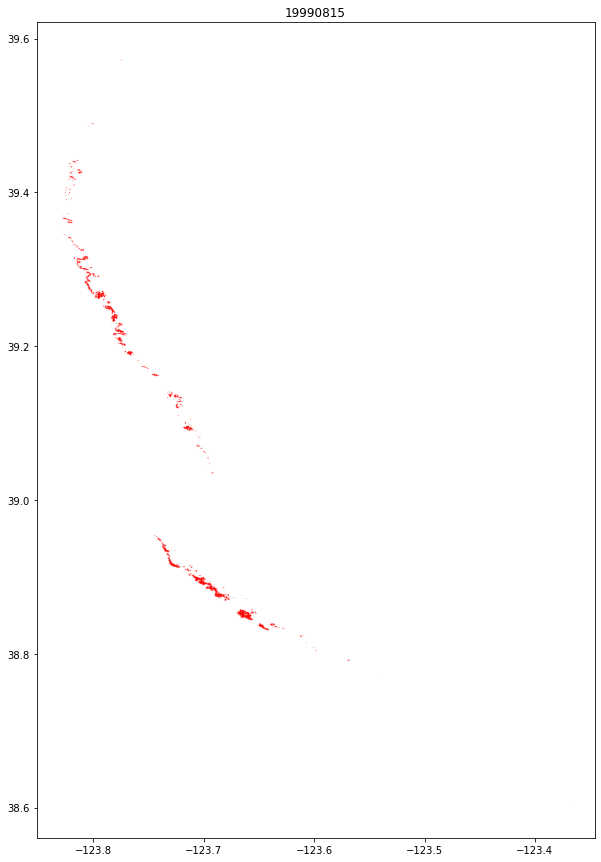

/Volumes/Mere/Python_MESMA/PyMESMA_McPhersonROI_timeseries_results/to_fix/LS_PyMESMA_19990831_20200414.csv


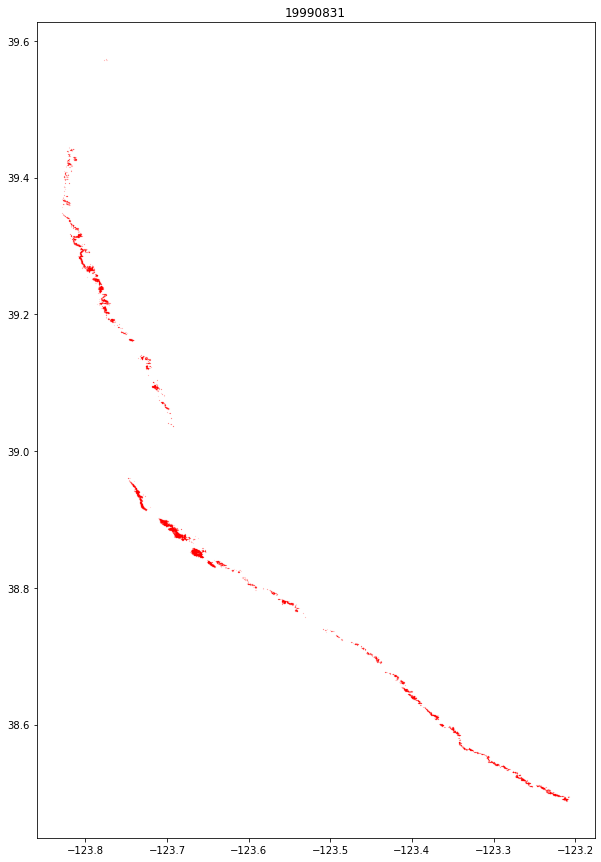

/Volumes/Mere/Python_MESMA/PyMESMA_McPhersonROI_timeseries_results/to_fix/LS_PyMESMA_19991017_20200414.csv


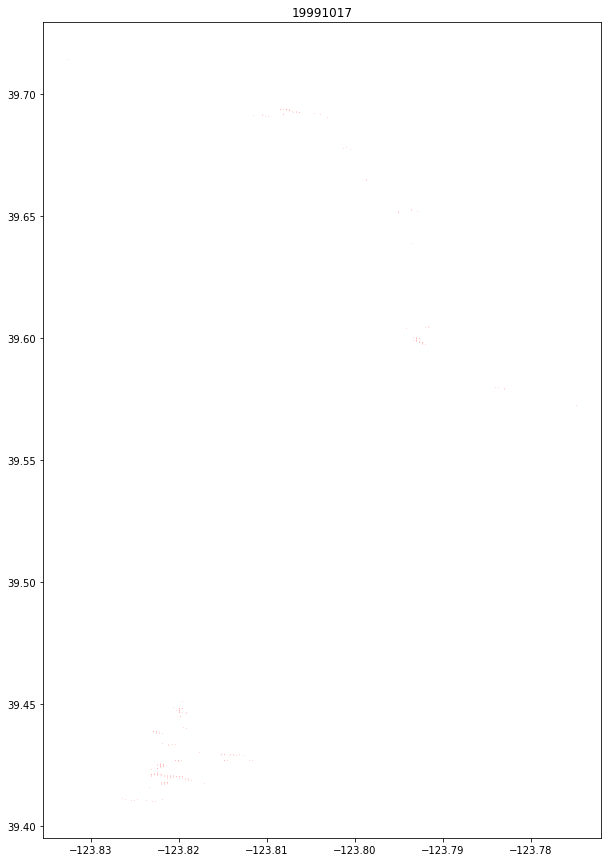

/Volumes/Mere/Python_MESMA/PyMESMA_McPhersonROI_timeseries_results/to_fix/LS_PyMESMA_20130813_20200414.csv


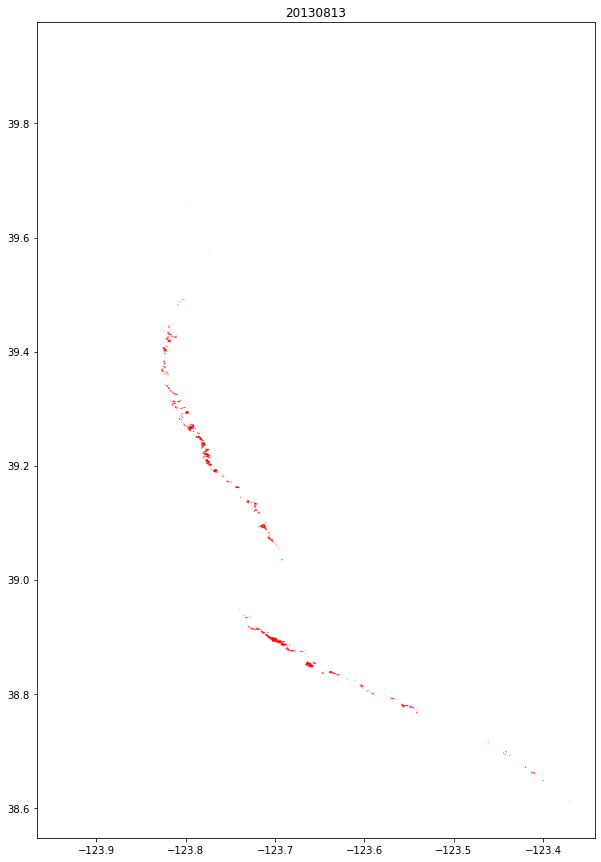

/Volumes/Mere/Python_MESMA/PyMESMA_McPhersonROI_timeseries_results/to_fix/LS_PyMESMA_20130905_20200414.csv


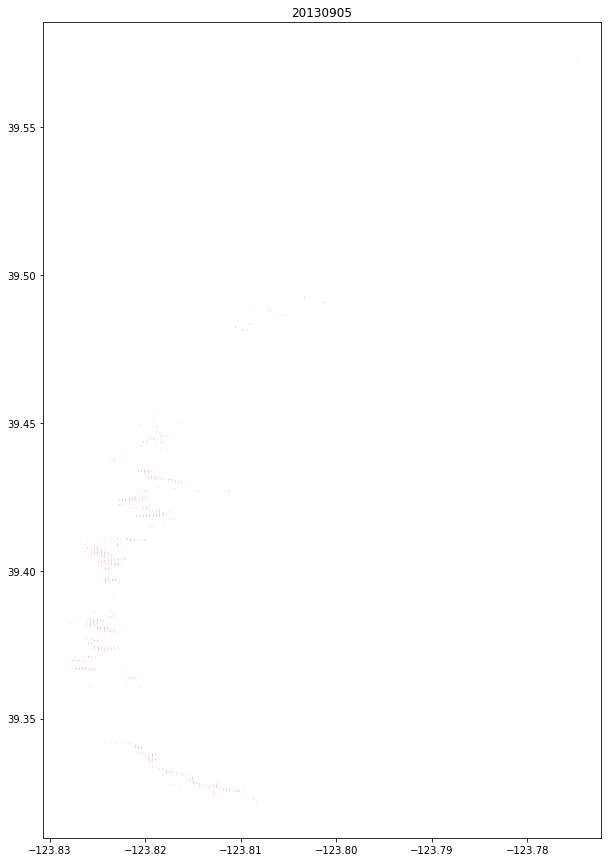

/Volumes/Mere/Python_MESMA/PyMESMA_McPhersonROI_timeseries_results/to_fix/LS_PyMESMA_20130906_20200414.csv


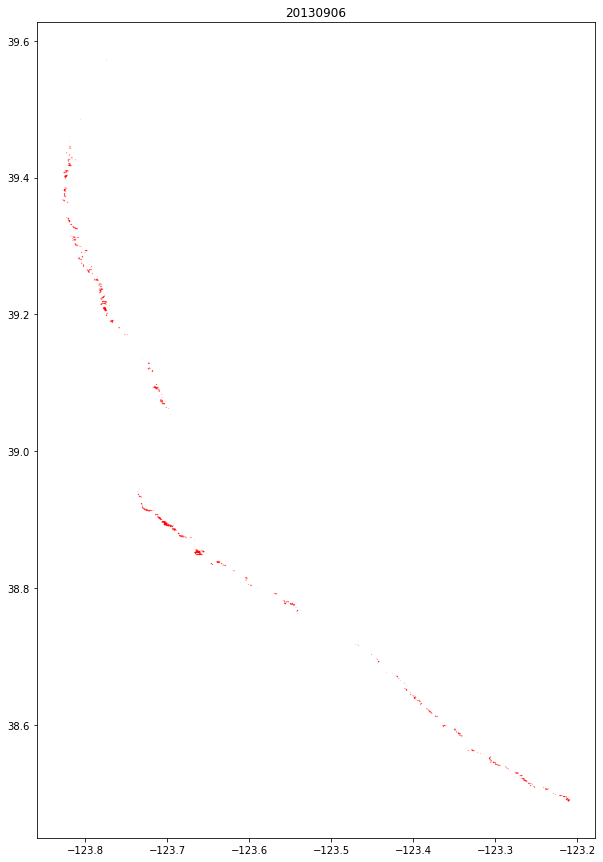

/Volumes/Mere/Python_MESMA/PyMESMA_McPhersonROI_timeseries_results/to_fix/LS_PyMESMA_20131016_20200414.csv


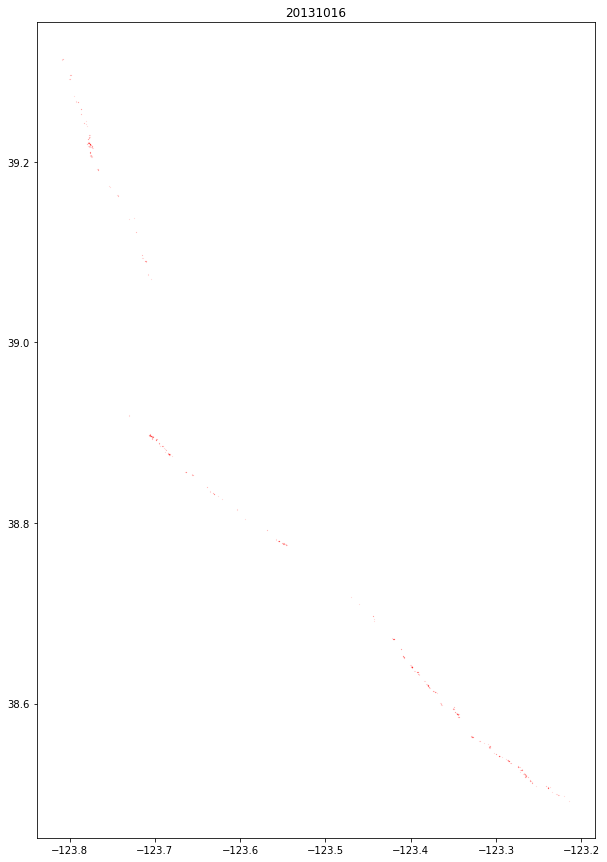

In [7]:
# import csv files and look at the results more closely
csv_filelist = glob.glob('/Volumes/Mere/Python_MESMA/PyMESMA_McPhersonROI_timeseries_results/to_fix/*.csv')
#csv_filelist.extend(glob.glob('PyMESMA_McPhersonROI_timeseries_results/*_20191119.csv'))
csv_filelist.sort(key = lambda csv_filelist: csv_filelist[97:101])


for file in csv_filelist:
    print(file)
    df = pd.read_csv(file,delimiter = ' ',skiprows=3, names=['Y', 'Latitude', 'X', 'Longitude','pyMESMA Kelp Fraction']) 
    
    fig = plt.subplots(1,1,figsize = (10,15))
#     m = Basemap(resolution = 'h',
#             projection = 'merc',
#             lat_0 = np.median(lats), lon_0 = np.median(lons),
#             llcrnrlon = lons.min(), llcrnrlat = lats.min(), urcrnrlon = lons.max(), urcrnrlat = lats.max(),ax=ax1,epsg=3857)
    
#     m.fillcontinents(color='grey',zorder=2)
#     m.drawmapboundary(color='azure',zorder=1)
#     parallels = np.arange(int(round(lats.min(),0)), int(round(lats.max(),0))+1, 1)
#     m.drawparallels(parallels,labels=[False,True],color='white',textcolor='white')
#     meridians = np.arange(int(round(lons.min(),0)), int(round(lons.max(),0))+1, 1)
#     m.drawmeridians(meridians,labels=[True,True],color='white')
#     m.drawcoastlines()
#     m.drawcounties(zorder=20)
#     ax1.tick_params(axis ='y', labelsize = 14, colors='white')
#     x,y = m(np.array(df['Longitude']),np.array(df['Latitude']))
    plt.plot(df['Longitude'],df['Latitude'],'r.',markersize=0.1,zorder=3)
    
    plt.title(file[85:93])
    plt.show()



In [ ]:
# ------ create an array of max kelp extent from all the years

# bring in all the text files to create 3D array for 
# output_filelist = []
# output_filelist = glob.glob('PyMESMA_McPhersonROI_climatology/results/LS_PyMESMAfrac_max_*.txt')
# output_filelist.sort(key = lambda output_filelist: output_filelist[70:79])

output_filelist = []
output_filelist = glob.glob('PyMESMA_McPhersonROI_timeseries_results/*frac_max_*.txt')
output_filelist.sort(key = lambda output_filelist: output_filelist[75:83])

# create array of zeros to populate with timeseries of MESMA kelp fractions
test = np.loadtxt(output_filelist[0])
output_stack = np.zeros((len(test),test.shape[1],len(output_filelist)))

for f,file in enumerate(output_filelist):
    print(file)
    load = np.loadtxt(file)
    output_stack[:,:,f] = load

where_are_NaNs = np.isnan(output_stack)
output_stack[where_are_NaNs] = 0.


In [28]:
# ------ create an array of max kelp extent
now = datetime.now().strftime('%Y%m%d')

max_extent = np.zeros((len(output_stack),output_stack.shape[1]))
for r in range(output_stack.shape[0]):
    for c in range(output_stack.shape[1]):
        if output_stack[r,c,:].any() > 0.: 
            max_extent[r,c] = 1.0
        else:
            continue

max_extent_array = np.dstack((max_extent,northings,eastings))

max_extent_loc = np.where(max_extent == 1.0)
max_northings = np.array(northings[max_extent_loc[0],max_extent_loc[1]]).reshape(-1,1)
max_lats = np.array(lats[max_extent_loc[0],max_extent_loc[1]]).reshape(-1,1)
max_eastings = np.array(eastings[max_extent_loc[0],max_extent_loc[1]]).reshape(-1,1)
max_lons = np.array(longs[max_extent_loc[0],max_extent_loc[1]]).reshape(-1,1)
max_all = np.hstack((max_northings,max_lats,max_eastings,max_lons))
    
# np.savetxt(f'PyMESMA_McPhersonROI_climatology/results/LS_PyMESMA_max_extent_locations_{now}.csv',
#            max_all, 
#            delimiter=",", 
#            fmt = '%i %0.7f %i %0.7f',
#            header = f'Max extent from Python MESMA run on {now} \n {frac_range} \n Northings (y); Latitude; Eastings (x) Longitude')


In [ ]:
# plot the max kelp extent

mk = pd.read_csv(f'PyMESMA_McPhersonROI_climatology/results/LS_PyMESMA_max_extent_locations_20200121.csv',
                 delimiter = ' ',
                 skiprows=3, 
                 names=['Y', 'Latitude', 'X', 'Longitude']) 

fig = plt.subplots(1,1,figsize = (10,15))
plt.scatter(np.array(mk['X']),np.array(mk['Y']),s=1,color = 'red',label='max extent')
plt.legend()
plt.title('max extent for all years in timeseries')
plt.show()


In [ ]:
# LS7 Gap Filling Algorithm - VERSION 5
# Tom Bell
# Dec 7, 2018

# INSTRUCTIONS
# For this version of the gap filling code I have removed the temporal
# interpolation step (which used to be Step 2), so all that is completed is
# Step 1. Spatial Synchrony gap filling. You can see Step 2. commented out
# at the bottom.

# You need to start with 2 variables here:
# 1. A space/time matrix of kelp fractions or biomass with SLC error values
# set to a value of -999, this should be called 'kelp_bio'
# 2. A 'coords' matrix with Lat/Lon coordinates

# F_Vals1 = Estimated kelp values used to fill the SLC errors
# F_Vals1_CI = 95% CI of those estimated values (2 * SE)
# kelp_bio_L1 = the combined kelp_bio and filled values

# pyton scripting for lsqfitx, lsqfity, and lsqfitgm from - http://pydoc.net/oceans/0.4.0/oceans.ff_tools.teaching/

date_string  = f'{datetime.now():%Y%m%d}'

# create a list of the LE07 files as text files to run through Tom's gap filling algorithm
LE07_filelist = []

# LE07_filelist = glob.glob('PyMESMA_McPhersonROI_climatology/results/*frac*LE07*.txt')
# LE07_filelist.sort(key = lambda LE07_filelist: LE07_filelist[70:78])


LE07_filelist = glob.glob('PyMESMA_McPhersonROI_timeseries_results/*frac*LE07*.txt')
LE07_filelist.sort(key = lambda LE07_filelist: LE07_filelist[75:83])

# create list of csv files with lat/lon/frac to append to
LE07_locations = []

# LE07_locations = glob.glob('PyMESMA_McPhersonROI_climatology/results/*LE07*.csv')
# LE07_locations.sort(key = lambda LE07_locations: LE07_locations[71:79])

LE07_locations = glob.glob('PyMESMA_McPhersonROI_timeseries_results/*LE07*.csv')
LE07_locations.sort(key = lambda LE07_locations: LE07_locations[61:69])


# pixel range is 600x600 m. 10 m N,S,E,W from the center 
pixrange = 10

Xi = np.arange(30,pixrange*2*30+30,30).reshape(20,1)
Xi = np.repeat(Xi,20,axis=1)

for l,file in enumerate(LE07_filelist):
    print(file)
    kelp_bio = np.loadtxt(file)
    kelp_bio1 = kelp_bio
    loc_list = pd.read_csv(LE07_locations[l],delimiter = ' ',skiprows=3, names=['Y', 'Latitude', 'X', 'Longitude','pyMESMA Kelp Fraction'])
    
    print(np.nanmax(kelp_bio))

    print('Determining SLC Error Pixels')
    try:
        for k in range(len(max_extent_loc[0])):

            pix = kelp_bio[max_extent_loc[0][k],max_extent_loc[1][k]]

            if pix == 0.:
                loc = max_extent_loc[0][k],max_extent_loc[1][k]

                # get array of pixel x and y locations for 300 m radius (10 pixels in each direction)
                Cy = np.arange(max_extent_loc[0][k]-pixrange,max_extent_loc[0][k]+pixrange,1)
                Cx = np.arange(max_extent_loc[1][k]-pixrange,max_extent_loc[1][k]+pixrange,1)
                Cxy = np.meshgrid(Cy,Cx)
                fracs = []


                for i in range(len(Cxy[0])):
                    finders = np.vstack((Cxy[0][1],Cxy[1][i])).T
                    fracs.extend(kelp_bio[finders[:,0],finders[:,1]])

                # calcualte if >70% of nearby pixels show zero detected canopy biomass 
                # if >70% fill with a value of nan
                # do this first b/c it seems like most of the pixels will actually be removed this way

                fracs = np.asarray(fracs).reshape((20,20))
                count = np.isnan(fracs).sum() + fracs[fracs == 0.].size

                if count > 0.7*fracs.size:
                    kelp_bio1[loc[0],loc[1]] = np.nan

                else:
                    #print('FIX ME!')

                    # geometric mean variables: 

                    # m, b, r, sm, sb = lsqfitgm(X,Y)
                    # X    =    x data (vector)
                    # Y    =    y data (vector)
                    # m    =    slope
                    # b    =    y-intercept
                    # r    =    correlation coefficient
                    # sm   =    standard deviation of the slope
                    # sb   =    standard deviation of the y-intercept

                    # replace kelp_bio1 pixel value with new estimate
                    X, Y = list(map(np.asanyarray, (Xi[(fracs != 0.) & (~np.isnan(fracs))], fracs[(fracs != 0.) & (~np.isnan(fracs))])))

                    # Determine the size of the vector.
                    n = len(X)

                    # Calculate sums and means.
                    Sx = np.sum(X)
                    Sy = np.sum(Y)
                    xbar = Sx / n
                    ybar = Sy / n

                    # ----- Determine slope of Y-on-X regression.
                    Sx2 = np.sum(X ** 2)
                    Sxy = np.sum(X * Y)
                    Sy2 = np.sum(Y ** 2)

                    # Calculate re-used expressions.
                    numy = n * Sxy - Sx * Sy
                    deny = n * Sx2 - Sx ** 2

                    # Calculate my, by, ry, s2, smy and sby.
                    my = numy / deny
                    by = (Sx2 * Sy - Sx * Sxy) / deny
                    ry = numy / (np.sqrt(deny) * np.sqrt(n * Sy2 - Sy ** 2))

                    diff = Y - by - my * X

                    s2 = np.sum(diff * diff) / (n - 2)
                    smy = np.sqrt(n * s2 / deny)
                    sby = np.sqrt(Sx2 * s2 / deny)

                    # ----- Determine slope of X-on-Y regression.

                    # Calculate re-used expressions.
                    numx = n * Sxy - Sy * Sx
                    denx = n * Sy2 - Sy ** 2

                    # Calculate m, a, rx, s2, sm, and sb.
                    mxi = numx / denx
                    a = (Sy2 * Sx - Sy * Sxy) / denx
                    rx = numx / (np.sqrt(denx) * np.sqrt(n * Sx2 - Sx ** 2))

                    diff = X - a - mxi * Y

                    s2 = np.sum(diff * diff) / (n - 2)
                    sm = np.sqrt(n * s2 / denx)
                    sa = np.sqrt(Sy2 * s2 / denx)

                    # Transpose coefficients
                    mx = 1 / mxi
                    bx = -a / mxi

                    smx = mx * sm / mxi
                    sbx = np.abs(sa / mxi)

                    # Calculate geometric mean slope.
                    m = np.sqrt(my * mx)

                    if (my < 0) and (mx < 0):
                        m = -m


                    # Calculate geometric mean intercept.
                    b = ybar - m * xbar

                    # Calculate more sums.
                    Sx2 = np.sum(X ** 2)

                    # Calculate re-used expressions.
                    den = n * Sx2 - Sx ** 2

                    # Calculate r, sm, sb and s2.

                    r = np.sqrt(my / mx)

                    if (my < 0) and (mx < 0):
                        r = -r

                    diff = Y - b - m * X

                    s2 = np.sum(diff * diff) / (n - 2)
                    sm = np.sqrt(n * s2 / den)
                    sb = np.sqrt(Sx2 * s2 / den)

                    val = m * 0 + b

                    if r >= 0.5:
                        print('loc = ',loc)
                        print('r = ',r)
                        print('mean frac =', np.mean(Y))

                        # plot for a lookie look.
                        plt.scatter(X,Y)
                        plt.show()

                        # Take the mean of all the surrounding kelp fractions to get the replacement kelp fraction value
                        mean_frac = np.nanmean(Y)
                        kelp_bio1[loc[0],loc[1]] = mean_frac

                        #location data needs to be added to existing kelp location data
                        new_row = {'Y':northings[loc[0],loc[1]],
                                   'Latitude':lats[loc[0],loc[1]],
                                   'X':eastings[loc[0],loc[1]],
                                   'Longitude':longs[loc[0],[1]],
                                   'pyMESMA Kelp Fraction':mean_frac}
                        loc_list.append(new_row, ignore_index=True)
        np.savetxt(f'{LE07_locations[l][0:-4]}_gapfilled_{date_string}.csv',
                   loc_list, 
                   delimiter=",", 
                   fmt = '%i %0.7f %i %0.7f %0.5f',
                   header = f'Python MESMA for {file[65:-4]} run on {date_string} \n MESMA frac range = 0.2-1 \n Northings (y); Latitude; Eastings (x) Longitude; Kelp Fraction')

        # for later processing of autocorrelation, etc.
        np.savetxt(f'{file[0:-4]}_gapfilled_{date_string}.txt',
                   kelp_bio1, 
                   fmt = '%0.3f')
    except IndexError:
        continue
    #save kelp_bio1 as corrected kelp fraction as both a grid and w/lat and lon locations




            
            
